<a href="https://colab.research.google.com/github/orengerc/wien-filter/blob/main/notebooks_Wein_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wein Filter

## Part 1 - Calculating trajectory of a particle under constant magnetic & electric fields;

#### Import the desired libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import IntEnum

#### Define the proper variables and initial conditions:

In [2]:
class Coordinate(IntEnum):
    """
    Defines the coordinates used in the excercise.
    """
    X = 0
    Y = 1
    Z = 2


# Constants of the problem
E = 5
B = 1
q = 1
m = 1

# initialize the variables
omega = q * B / m
T = 2 * np.pi / omega
DELTA_T = 0.01
N = int(T / DELTA_T)

r, v = np.zeros((N, 3)), np.zeros((N, 3))
v[0][2] = 3 * E / B

#### Funtions that calculate the position and velocity of the particle:

In [3]:
def update_position(i, method):
    """
    Updates position vector of the charged particle.
    :param i: iteration we are on
    :return: nothing
    """
    if method == 'TAYLOR':
        r[i, :] = r[i - 1, :] + v[i - 1, :] * DELTA_T
    elif method == 'MIDPOINT':
        r[i, :] = r[i - 1, :] + v[i - 1, :] * DELTA_T


        # # calculate v at half dt
        #
        # accelerations = calculate_accelerations(v[i - 1, :])
        # v_half = v[i - 1, :] + 0.5 * accelerations * DELTA_T
        #
        # k2 = DELTA_T * v_half
        #
        # # v_n+1 = v_n + k2
        # r[i, :] = r[i - 1, :] + k2
    elif method == 'RUNGE-JUTTA':
        pass


def calculate_accelerations(velocities):
    factor = q / m
    return np.array(
        [0, factor * (E - B * velocities[Coordinate.Z]),
         factor * B * velocities[Coordinate.Y]])


def update_velocity(i, method):
    """
    Updates velocity vector of the charged particle.
    :param i: iteration we are on
    :return: nothing
    """

    accelerations = calculate_accelerations(v[i - 1, :])
    if method == 'TAYLOR':
        v[i, :] = v[i - 1, :] + accelerations * DELTA_T
    elif method == 'MIDPOINT':
        v[i, :] = v[i - 1, :] + accelerations * DELTA_T
        # k1 = DELTA_T * accelerations
        #
        # v_half = v[i - 1, :] + 0.5 * k1
        # a_half = calculate_accelerations(v_half)
        #
        # k2 = DELTA_T * a_half
        #
        # # v_n+1 = v_n + k2
        # v[i, :] = v[i - 1, :] + k2

    elif method == 'RUNGE-JUTTA':
        pass


def calculate(method):
    """
    Iterates until end of T, each iteration calculating the current positions and velocities.
    :return: nothing
    """
    for i in range(N - 1):
        update_velocity(i + 1, method)
        update_position(i + 1, method)
        

def graph_motion():
    """
    Plots position and velocity of particle in the Y axis vs. Z axis
    :return: nothing
    """
    # graph position of particle in Z,Y plane
    plt.plot(r[:, Coordinate.Y], r[:, Coordinate.Z])
    plt.title("Position of particle in Z,Y plane")
    plt.xlabel("Y [Arbitrary Units]")
    plt.xlabel("Z [Arbitrary Units]")
    plt.plot()
    plt.show()

    # graph position of particle in 3D
    ax = plt.axes(projection='3d')
    ax.scatter3D(r[:, Coordinate.X], r[:, Coordinate.Y], r[:, Coordinate.Z], c=r[:, Coordinate.Z], cmap='Greens')
    plt.show()

    # graph velocity of particle in Z,Y plane
    plt.plot(v[:, Coordinate.Y], v[:, Coordinate.Z])
    plt.title("Velocity of particle in Z,Y plane")
    plt.xlabel("Velocity in Y direction [Arbitrary Units]")
    plt.ylabel("Velocity in Z direction [Arbitrary Units]")
    plt.plot()
    plt.show()


def graph_error():
    pass


def run(method):
    """
    Calculates the positions and velocities at any time using the desired method,
    then graphs the positions and velocities and their accumulated error.
    :return:
    """
    calculate(method)
    graph_motion()
    graph_error()


def reset():
    global r, v
    r, v = np.zeros((N, 3)), np.zeros((N, 3))

#### Simple Taylor's method:

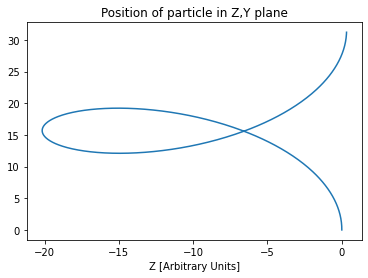

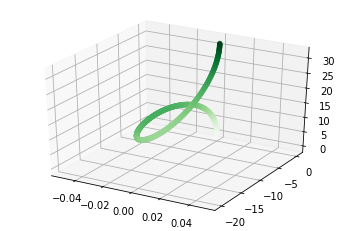

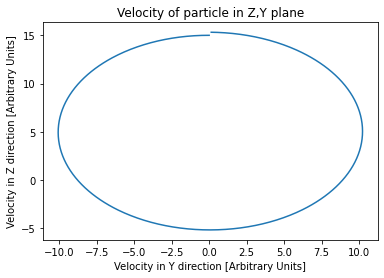

In [4]:
run("TAYLOR")
reset()

#### Midpoint method:

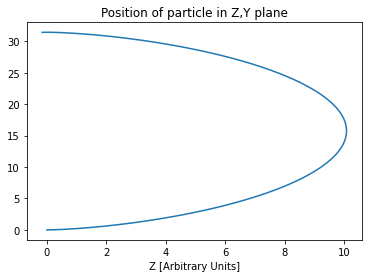

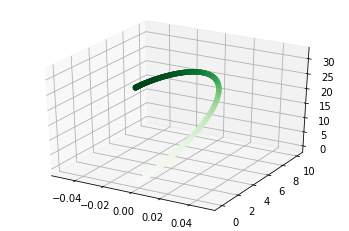

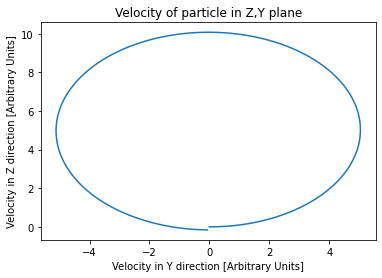

In [5]:
run("MIDPOINT")
reset()

#### Runge-Jutta (4th order) method:

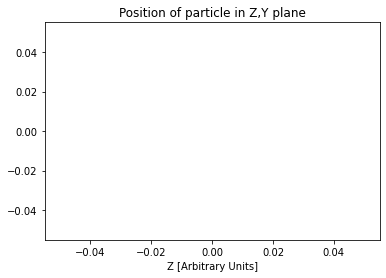

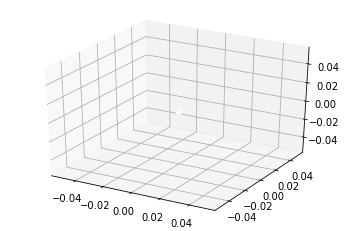

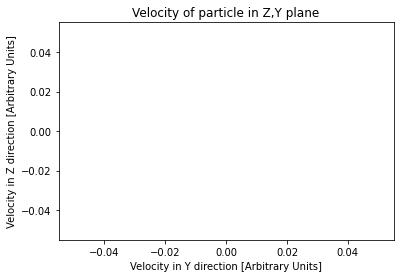

In [6]:
run("RUNGE-JUTTA")
reset()